# Optimización de la extracción de oro

Trabajas para la compañía de eficiencia industrial Zyfra. Tu tarea es optimizar el proceso de extracción de oro a partir de mineral de oro.
Pasos para mejorar la extracción:

- Recolecta los datos de extracción y purificación del mineral de oro: calidad del mineral, volumen y eficiencia de la recuperación
- Construye un modelo para predecir la cantidad de oro que puede ser extraída del mineral
- Optimiza la producción eliminando parámetros no rentables basándose en las predicciones del modelo
- Selecciona el proceso de extracción y purificación más eficiente con el mayor rendimiento de oro

Tienes datos sobre el proceso de extracción de oro en varias etapas. Los parámetros de cada etapa del proceso de extracción y purificación son conocidos. Crea un modelo que ayude a elegir el proceso más eficiente y rentable. Analiza las predicciones y posibles mejoras utilizando técnicas de aprendizaje automático.

# Descripción de los datos

Características (elegidas para el entrenamiento del modelo):

- `primary_cleaner.input.sulfate`: Cantidad de sulfato (sulfuro de sodio) añadido durante la etapa de purificación primaria.
- `primary_cleaner.input.depressant`: Cantidad de depresante (generalmente un tipo de polímero) añadido durante la etapa de purificación primaria.
- `primary_cleaner.input.feed_size`: Tamaño de las partículas en la alimentación de la etapa de purificación primaria.
- `primary_cleaner.input.xanthate`: Cantidad de xantato añadido durante la etapa de purificación primaria.
- `rougher.input.feed_ag`: Concentración de plata en la alimentación al proceso de flotación. 
- `rougher.input.feed_pb`: Concentración de plomo en la alimentación al proceso de flotación.
- `rougher.input.feed_rate`: Velocidad de alimentación de la mezcla mineral al proceso de flotación.
- `rougher.input.feed_size`: Tamaño de las partículas minerales en la alimentación al proceso de flotación.
- `rougher.input.feed_sol`: Concentración de sólidos disueltos en la alimentación al proceso de flotación.
- `rougher.input.feed_au`: Concentración de oro en la alimentación al proceso de flotación.
- `rougher.input.floatbank10_sulfate`: Cantidad de sulfato añadido en el proceso de flotación en la celda de flotación 10. 
- `rougher.input.floatbank10_xanthate`: Cantidad de xantato añadido en el proceso de flotación en la celda de flotación 10.
- `rougher.input.floatbank11_sulfate`: Cantidad de sulfato añadido en el proceso de flotación en la celda de flotación 11.
- `rougher.input.floatbank11_xanthate`: Cantidad de xantato añadido en el proceso de flotación en la celda de flotación 11.
- `final.output.recovery` - Recuperación de oro después de la purificación
- `rougher.output.recovery` - Recuperación de oro después de la flotación

Cada fila en el conjunto de datos corresponde a una medición tomada en una etapa específica del proceso de extracción de oro. Cada medición consta de varios parámetros como el tipo de materia prima, los reactivos añadidos, el tamaño de las partículas de la alimentación, la concentración de oro, etc.

# Inicialización

In [1195]:
# Carga todas las librerías

# Manipulación de datos
import pandas as pd
import numpy as np

# Modelado
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Preprocesamiento
import scipy.stats as st 

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns


# Cargar los datos

In [1196]:
# Carga los datos en DataFrames
try:
    df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
except Exception:
    df_full = pd.read_csv('datasets/gold_recovery_full.csv')
    df_test = pd.read_csv('datasets/gold_recovery_test.csv')
    df_train = pd.read_csv('datasets/gold_recovery_train.csv')

# Preparar los datos

In [1197]:
# Imprime la información general/resumen sobre el DataFrame
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [1198]:
# Imprime una muestra aleatoria de 5 filas del DataFrame
df_full.sample(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
11824,2017-05-21 15:59:59,6.814342,12.181653,9.944113,39.821933,62.843402,9.224331,3.281621,9.942055,3.676112,...,14.014576,-508.782292,11.987717,-502.049566,11.036253,-505.525526,9.971468,-500.644832,20.002594,-499.933907
18662,2018-03-02 13:59:59,5.764435,7.461034,8.851876,47.058580,77.938829,13.031187,2.010774,10.704215,2.308444,...,23.002667,-500.495118,14.961418,-499.680878,17.987472,-500.231250,12.037583,-500.247043,11.969940,-501.445409
11848,2017-05-22 15:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,24.946218,-546.949099,23.017606,-509.474263,25.979607,-500.959780,24.003058,-500.254891,17.985848,-499.197445
7243,2016-11-11 18:59:59,3.407337,9.618171,11.472761,48.114357,61.348624,8.816013,2.462063,12.037555,3.436658,...,16.000152,-499.657570,13.947055,-501.968322,15.227048,-498.734411,14.005083,-499.843625,22.003570,-499.089978
21032,2018-06-09 07:59:59,4.370101,12.492048,5.877357,43.644992,71.962142,8.096010,2.667173,9.244913,1.757176,...,30.021786,-500.287854,21.983202,-500.242058,24.995463,-500.437484,22.987272,-500.003374,24.988693,-484.699013


In [1199]:
# Imprime la información general/resumen sobre el DataFrame
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [1200]:
# Imprime una muestra aleatoria de 5 filas del DataFrame
df_test.sample(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
3545,2017-09-26 17:59:59,179.118855,6.000592,7.030000,2.037022,1311.536739,-499.841993,1284.541696,-501.118418,1308.790160,...,14.983648,-499.359137,12.946423,-394.798056,11.066620,-500.273639,8.944039,-500.108497,11.979094,-499.771495
5364,2017-12-11 12:59:59,190.660974,10.512683,8.370000,1.102894,1553.934907,-500.347756,1550.153686,-502.530938,1550.280901,...,20.029686,-499.982566,15.057208,-311.767895,10.913145,-500.076529,8.019266,-499.722908,11.981012,-500.110697
192,2016-09-09 00:59:59,118.189551,6.985126,8.085333,0.502660,1301.473850,-500.315703,1297.894822,-500.493414,1300.246311,...,8.046431,-499.606055,4.883971,-599.895551,8.128963,-594.529088,3.063712,-597.665229,19.975706,-599.628675
965,2016-10-11 05:59:59,203.458011,11.018292,7.400000,0.998445,1497.473581,-500.722112,1497.256008,-500.368835,1498.632846,...,12.077235,-499.980478,11.925122,-500.103649,10.255587,-500.860192,7.050651,-499.842232,17.029409,-501.700797
4462,2017-11-03 22:59:59,214.296047,9.492539,7.280000,2.105297,1400.309346,-500.448637,1401.512008,-485.357148,1394.584857,...,20.023109,-499.416294,17.914164,-499.109102,13.955797,-499.926645,9.957244,-499.928302,13.997317,-499.432415


In [1201]:
# Imprime la información general/resumen sobre el DataFrame
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [1202]:
# Imprime una muestra aleatoria de 5 filas del DataFrame
df_train.sample(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
9358,2017-06-09 21:59:59,5.367773,10.267479,7.658246,44.276828,56.768400,8.468390,2.907905,8.636520,3.158948,...,14.971288,-500.606304,9.925280,-379.995955,15.009092,-499.884001,10.015379,-499.995722,15.036935,-499.787218
13362,2018-03-25 17:59:59,4.260716,12.088629,8.142380,45.341532,69.291072,9.521365,3.045868,8.287731,2.838829,...,22.937312,-499.778447,14.997429,-499.542754,17.980039,-499.833844,12.011103,-500.161083,12.990449,-499.779340
13233,2018-03-20 08:59:59,4.722359,9.541287,8.482018,46.432475,66.769927,9.362789,2.050339,9.401438,2.516652,...,23.052324,-500.649431,14.933124,-500.203210,30.003613,-500.282485,15.008345,-500.079843,13.000873,-500.069609
3276,2016-05-30 11:59:59,4.067986,9.163729,9.168172,45.994551,65.411370,6.924309,2.051623,13.231548,2.445883,...,10.027049,-499.925740,8.084380,-499.143120,8.028463,-499.754837,6.030558,-500.159004,18.035651,-499.507651
4037,2016-07-01 04:59:59,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,16.959342,-498.556000,8.980400,-500.160292,16.993480,-356.441918,8.018771,-155.836972,25.021181,-204.752479


## Comprobación del cálculo de la recuperación

`R = ((C x (F - T)) / (F x (C - T))) * 100`

dónde:

- **C** —> Proporción de oro en el concentrado justo después de la flotación (para saber la recuperación del concentrado rougher)/después de la purificación (para saber la recuperación del concentrado final).

- **F** —> Proporción de oro en la alimentación antes de la flotación (para saber la recuperación del concentrado rougher)/en el concentrado justo después de la flotación (para saber la recuperación del concentrado final).

- **T** —> Proporción de oro en las colas rougher justo después de la flotación (para saber la recuperación del concentrado rougher)/después de la purificación (para saber la recuperación del concentrado final).

In [1203]:
# Generar una copia del DataFrame sin los valores nulos
df_train_dropna = df_train.dropna().reset_index(drop=True)

# Proporción de oro en el concentrado justo después de la flotación
c = df_train_dropna['rougher.output.concentrate_au']
c = c[df_train_dropna['rougher.output.recovery'].index]

# Proporción de oro en la alimentación antes de la flotación
f = df_train_dropna['rougher.input.feed_au']
f = f[df_train_dropna['rougher.output.recovery'].index]

# Proporción de oro en las colas rougher justo después de la flotación
t = df_train_dropna['rougher.output.tail_au']
t = t[df_train_dropna['rougher.output.recovery'].index]

In [1204]:
# Cálculo de la recuperación de oro con la función
recovery = ((c * (f - t)) / (f * (c - t))) * 100
print(f'Recuperación de oro (cálculo): {recovery.mean()}')

# Recuperación de oro en el conjunto de entrenamiento
rougher_output_recovery = df_train_dropna['rougher.output.recovery']
print(f'Recuperación de oro (incluído): {rougher_output_recovery.mean()}')

Recuperación de oro (cálculo): 82.7418884610155
Recuperación de oro (incluído): 82.7418884610155


In [1205]:
# Calcula el MAE
mae = mean_absolute_error(rougher_output_recovery, recovery)
print('MAE:', mae)

MAE: 9.460144184559453e-15


## Características presentes en el conjunto de entrenamiento pero ausentes en el conjunto de prueba

In [1206]:
# Crea una lista con las características del conjunto de entrenamiento
train_columns = df_train.columns.tolist()

# Crea una lista con las características del conjunto de prueba
test_columns = df_test.columns.tolist()

# Crea una lista con las características que están en el conjunto de entrenamiento pero no en el conjunto de prueba
train_not_test = [x for x in train_columns if x not in test_columns]

# Muestra las características que están en el conjunto de entrenamiento pero no en el conjunto de prueba
df_train[train_not_test].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                                16794 non-null  float64


## Preprocesamiento

- Tomando en cuenta que los datos están indexados por la fecha y hora de adquisición, un enfoque sensato podría ser utilizar la imputación de series temporales para rellenar los valores faltantes.

In [1207]:
# Imputa los valores faltantes con el método 'ffill' (forward fill)
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)
df_full.fillna(method='ffill', inplace=True)

print('Valores faltantes en el conjunto de entrenamiento:', df_train.isna().sum().sum())
print('Valores faltantes en el conjunto de prueba:', df_test.isna().sum().sum())
print('Valores faltantes en el conjunto completo:', df_full.isna().sum().sum())

Valores faltantes en el conjunto de entrenamiento: 0
Valores faltantes en el conjunto de prueba: 0
Valores faltantes en el conjunto completo: 0


# Analizar los datos

## Cambio en la concentración de metales

Etapas de purificación:

- rougher.input.feed — materia prima
- rougher.output.concentrate — concentrado rougher
- final.output.concentrate — concentrado final

In [1208]:
# Crea una lista con las características que contienen las diferentes etaapas de purificación
stages = [
    'rougher.input.feed',
    'rougher.output.concentrate',
    'final.output.concentrate'
]

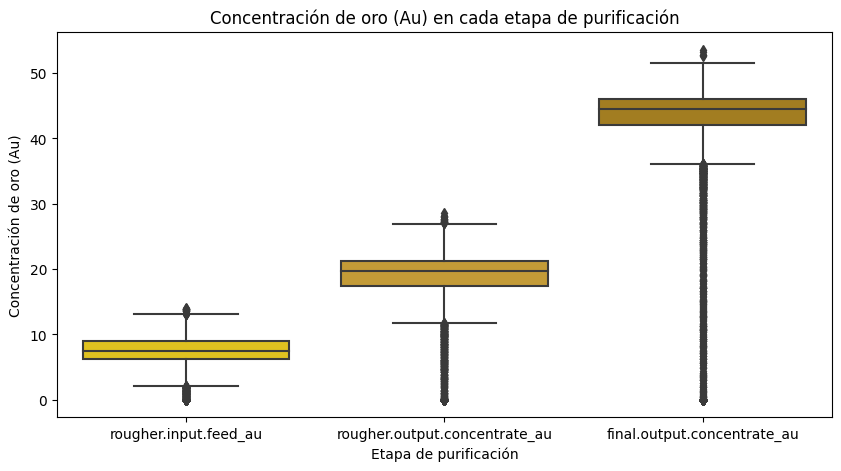

In [1209]:
# Determinar diferentes tonos de color oro (Au) para cada etapa de purificación
au_colors = ['#ffd700', '#daa520', '#b8860b']

# Crear un gráfico de caja con la concentración de oro (Au) en cada etapa de purificación
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_train[[f'{stage}_au' for stage in stages]], palette=au_colors)
plt.title('Concentración de oro (Au) en cada etapa de purificación')
plt.xlabel('Etapa de purificación')
plt.ylabel('Concentración de oro (Au)')
plt.show()

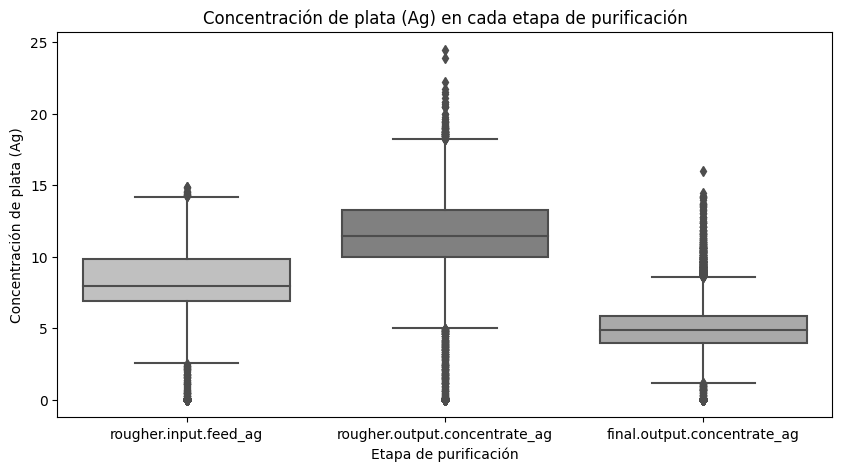

In [1210]:
# Determinar diferentes tonos de color plata (Ag) para cada etapa de purificación
ag_colors = ['#c0c0c0', '#808080', '#a9a9a9']

# Crear un gráfico de caja con la concentración de plata (Ag) en cada etapa de purificación
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_train[[f'{stage}_ag' for stage in stages]], palette=ag_colors)
plt.title('Concentración de plata (Ag) en cada etapa de purificación')
plt.xlabel('Etapa de purificación')
plt.ylabel('Concentración de plata (Ag)')
plt.show()

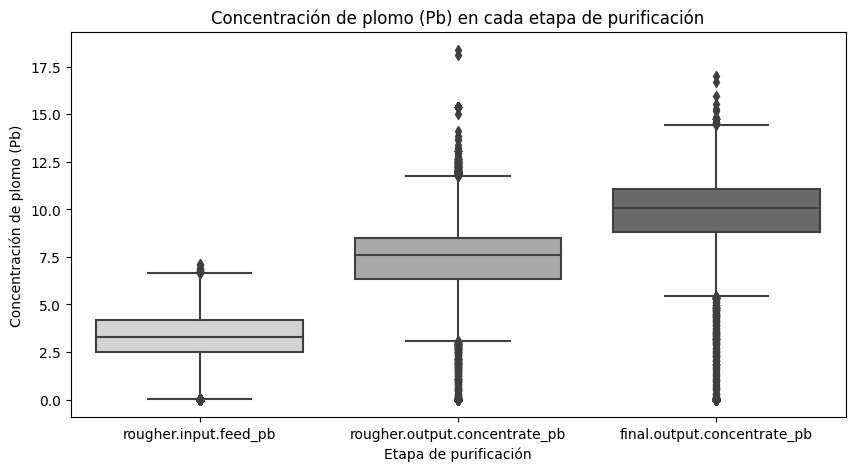

In [1211]:
# Determinar diferentes tonos de color plomo (Pb) para cada etapa de purificación
pb_colors = ['#d3d3d3', '#a9a9a9', '#696969']

# Crear un gráfico de caja con la concentración de plomo (Pb) en cada etapa de purificación
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_train[[f'{stage}_pb' for stage in stages]], palette=pb_colors)
plt.title('Concentración de plomo (Pb) en cada etapa de purificación')
plt.xlabel('Etapa de purificación')
plt.ylabel('Concentración de plomo (Pb)')
plt.show()

### Concentraciones totales

- `Oro (Au)`: La concentración de oro aumenta a medida que avanza el proceso, como se esperaría.
- `Plata (Ag)`: La concentración de plata aumenta inicialmente, pero luego disminuye en la etapa final, posiblemente debido a su eliminación para aumentar la pureza del oro.
- `Plomo (Pb)`: La concentración de plomo aumenta durante todo el proceso.

### Conclusión intermedia

En general, estos resultados son coherentes con lo que se esperaría de un proceso de purificación. Sin embargo, sería aconsejable buscar posibles anomalías en los datos, como valores extremos o concentraciones inusualmente bajas o altas, ya que pueden afectar al rendimiento del modelo.

## Comparación de distribuciones de tamaño de partículas

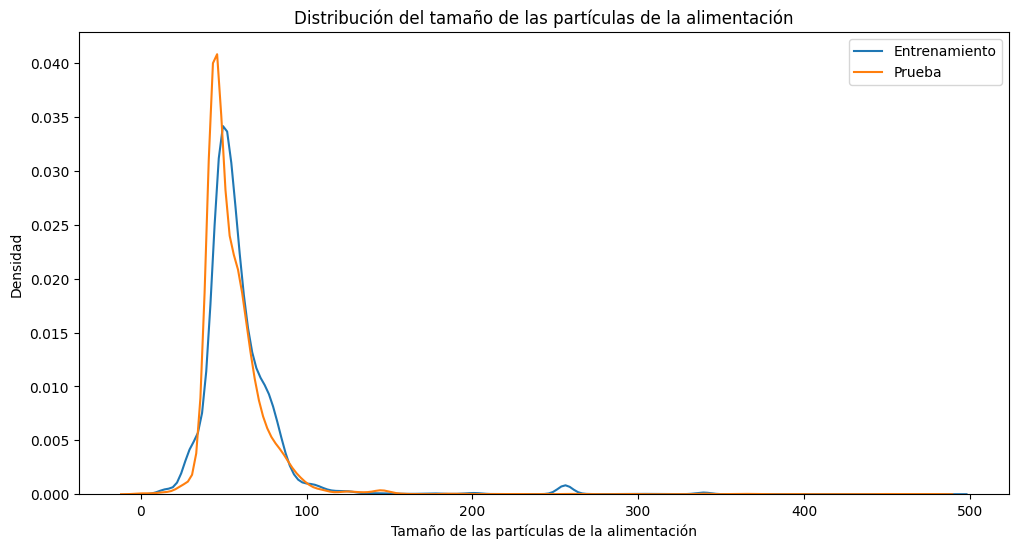

In [1212]:
# Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba
plt.figure(figsize=(12, 6))
sns.kdeplot(df_train['rougher.input.feed_size'], label='Entrenamiento')
sns.kdeplot(df_test['rougher.input.feed_size'], label='Prueba')
plt.title('Distribución del tamaño de las partículas de la alimentación')
plt.xlabel('Tamaño de las partículas de la alimentación')
plt.ylabel('Densidad')
plt.legend()
plt.show()

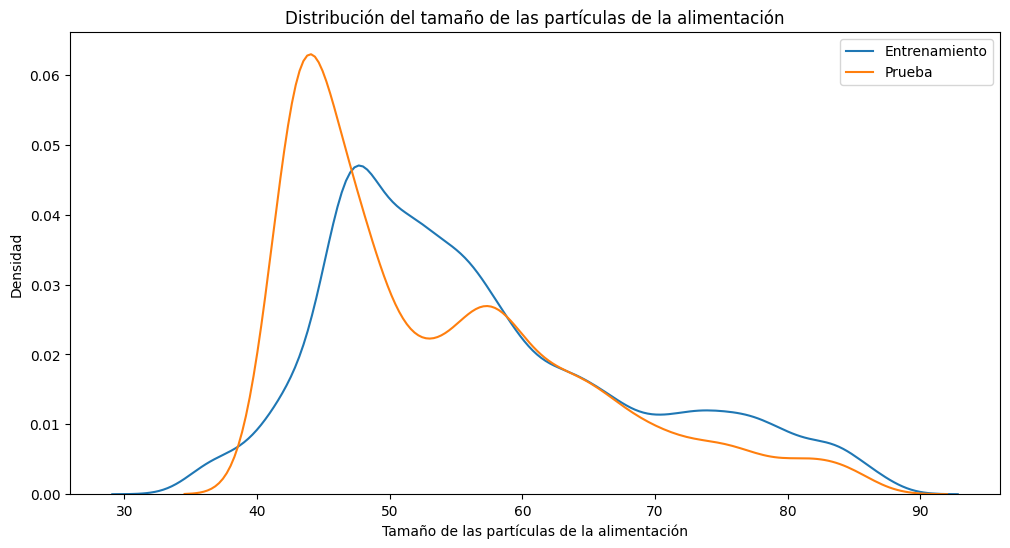

In [1213]:
# Deshacerse de los valores atípicos en ambos conjuntos de datos (entrenamiento y prueba) para el tamaño de las partículas de la alimentación

# Definir los límites de los cuantiles
lower_bound = 0.05
upper_bound = 0.95

# Calcular los cuantiles para el tamaño de las partículas de la alimentación en el conjunto de entrenamiento
q_lower_train = df_train['rougher.input.feed_size'].quantile(lower_bound)
q_upper_train = df_train['rougher.input.feed_size'].quantile(upper_bound)

# Calcular los cuantiles para el tamaño de las partículas de la alimentación en el conjunto de prueba
q_lower_test = df_test['rougher.input.feed_size'].quantile(lower_bound)
q_upper_test = df_test['rougher.input.feed_size'].quantile(upper_bound)

# Eliminar los valores atípicos en el conjunto de entrenamiento
df_train = df_train[df_train['rougher.input.feed_size'] > q_lower_train]
df_train = df_train[df_train['rougher.input.feed_size'] < q_upper_train]

# Eliminar los valores atípicos en el conjunto de prueba
df_test = df_test[df_test['rougher.input.feed_size'] > q_lower_test]
df_test = df_test[df_test['rougher.input.feed_size'] < q_upper_test]

# Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba
plt.figure(figsize=(12, 6))
sns.kdeplot(df_train['rougher.input.feed_size'], label='Entrenamiento')
sns.kdeplot(df_test['rougher.input.feed_size'], label='Prueba')
plt.title('Distribución del tamaño de las partículas de la alimentación')
plt.xlabel('Tamaño de las partículas de la alimentación')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [1214]:
# Comprobar si las distribuciones de las partículas de la alimentación son iguales en el conjunto de entrenamiento y en el conjunto de prueba
alpha = 0.05
results = st.ttest_ind(df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size'])

# H0: Las distribuciones no varían significativamente
# H1: Las distribuciones varían significativamente
if (results.pvalue < alpha):
    print('Se rechaza la hipótesis nula. Las distribuciones varían significativamente.')
else:
    print('NO se rechaza la hipótesis nula. Las distribuciones NO varían significativamente.')

Se rechaza la hipótesis nula. Las distribuciones varían significativamente.


### Conclusión intermedia

Las distribuciones de las partículas de la alimentación varían significativamente entre el conjunto de entrenamiento y en el conjunto de prueba.

# Preparar los datos

## Concentraciones totales de todas las sustancias en las diferentes etapas de purificación

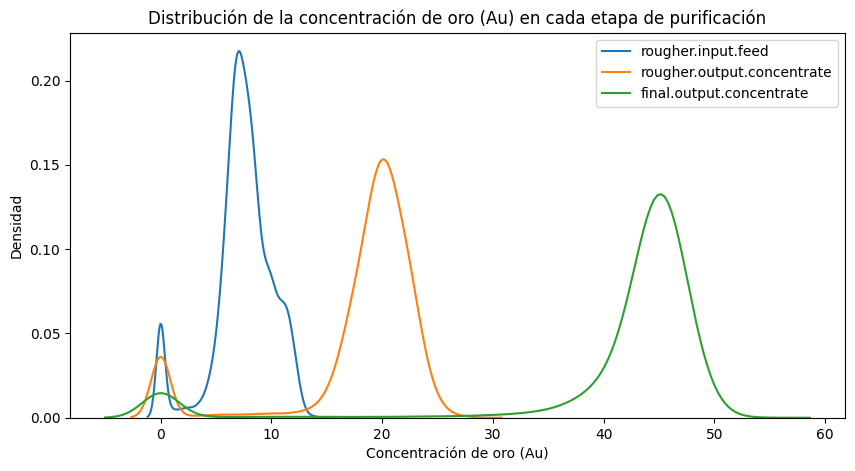

In [1215]:
# Mostrar la distribución de la concentración de oro (Au) en cada etapa de purificación
ig, ax = plt.subplots(figsize=(10, 5))
for stage in stages:
    sns.kdeplot(df_train[f'{stage}_au'], label=stage, ax=ax)
plt.title('Distribución de la concentración de oro (Au) en cada etapa de purificación')
plt.xlabel('Concentración de oro (Au)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

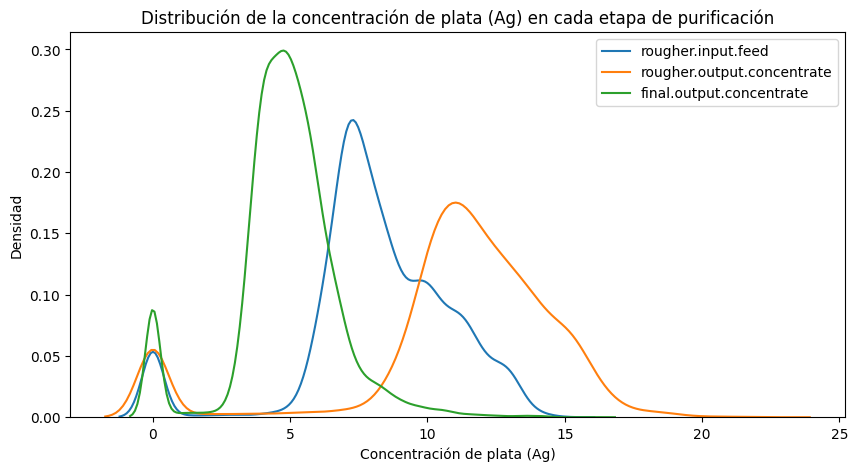

In [1216]:
# Mostrar la distribución de la concentración de plata (Ag) en cada etapa de purificación
ig, ax = plt.subplots(figsize=(10, 5))
for stage in stages:
    sns.kdeplot(df_train[f'{stage}_ag'], label=stage, ax=ax)
plt.title('Distribución de la concentración de plata (Ag) en cada etapa de purificación')
plt.xlabel('Concentración de plata (Ag)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

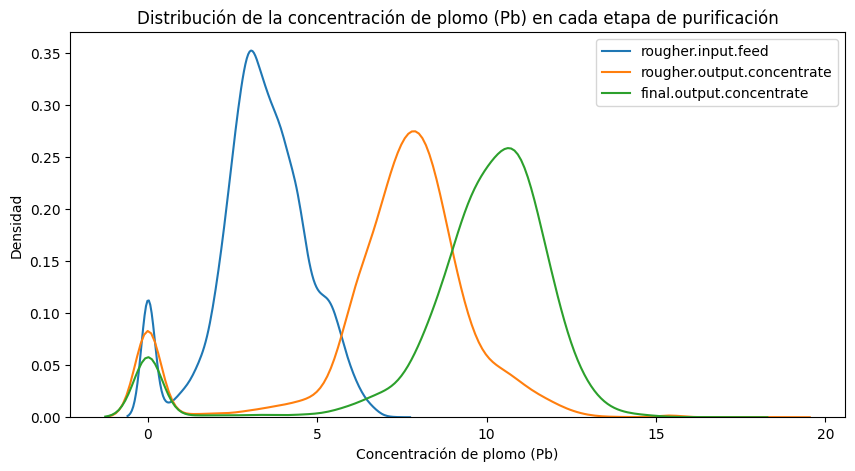

In [1217]:
# Mostrar la distribución de la concentración de plomo (Pb) en cada etapa de purificación
ig, ax = plt.subplots(figsize=(10, 5))
for stage in stages:
    sns.kdeplot(df_train[f'{stage}_pb'], label=stage, ax=ax)
plt.title('Distribución de la concentración de plomo (Pb) en cada etapa de purificación')
plt.xlabel('Concentración de plomo (Pb)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

### Conclusión intermedia

Las distribuciones de las concentraciones totales de todas las sustancias en las diferentes etapas de purificación contienen anomalías cercanas al cero, por lo que sería necesario eliminar dichas anomalías para poder entrenar el modelo de forma correcta.

## Eliminar las anomalías

In [1218]:
# Definir los límites de los cuantiles
lower_bound = 0.05
upper_bound = 0.95

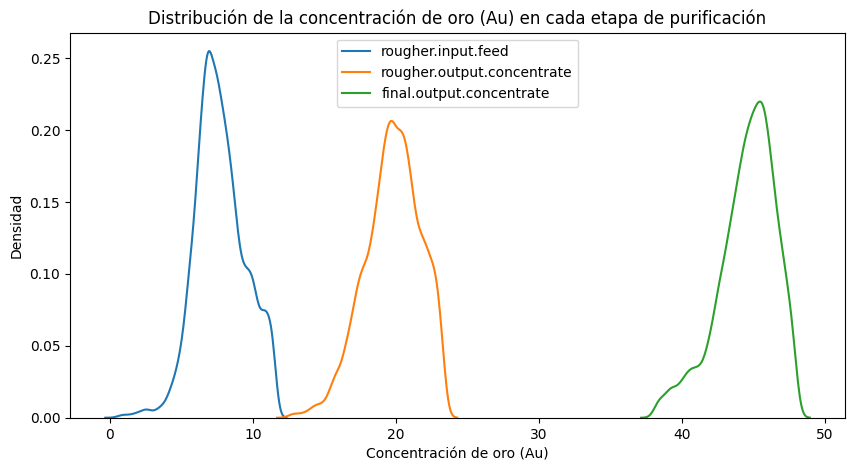

In [1219]:
# Eliminar las anomalías en las distribuciones de las concentraciones de oro (Au) en las diferentes etapas de purificación en el conjunto de entrenamiento
for stage in stages:
    q_low = df_train[f'{stage}_au'].quantile(lower_bound)
    q_hi  = df_train[f'{stage}_au'].quantile(upper_bound)
    df_train = df_train[(df_train[f'{stage}_au'] < q_hi) & (df_train[f'{stage}_au'] > q_low)]

# Mostar la distribución de la concentración de oro (Au) en cada etapa de purificación
ig, ax = plt.subplots(figsize=(10, 5))
for stage in stages:
    sns.kdeplot(df_train[f'{stage}_au'], label=stage, ax=ax)
plt.title('Distribución de la concentración de oro (Au) en cada etapa de purificación')
plt.xlabel('Concentración de oro (Au)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

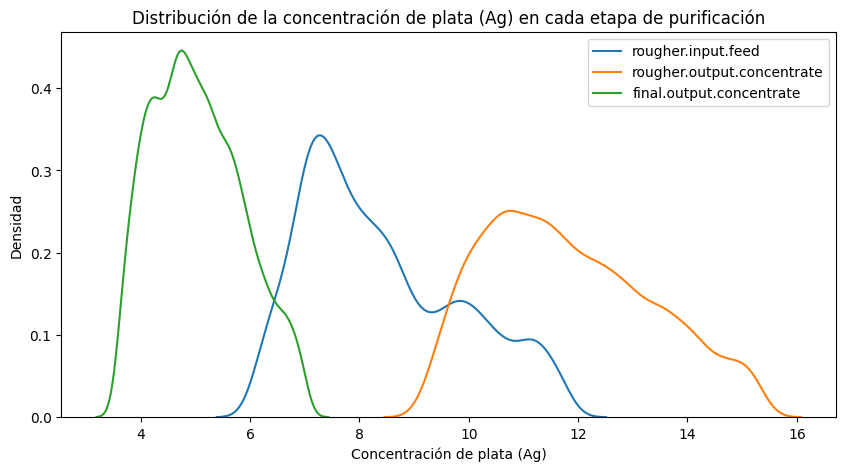

In [1220]:
# Eliminar las anomalías en las distribuciones de las concentraciones de plata (Ag) en las diferentes etapas de purificación en el conjunto de entrenamiento
for stage in stages:
    q_low = df_train[f'{stage}_ag'].quantile(lower_bound)
    q_hi  = df_train[f'{stage}_ag'].quantile(upper_bound)
    df_train = df_train[(df_train[f'{stage}_ag'] < q_hi) & (df_train[f'{stage}_ag'] > q_low)]

# Mostar la distribución de la concentración de plata (Ag) en cada etapa de purificación
ig, ax = plt.subplots(figsize=(10, 5))
for stage in stages:
    sns.kdeplot(df_train[f'{stage}_ag'], label=stage, ax=ax)
plt.title('Distribución de la concentración de plata (Ag) en cada etapa de purificación')
plt.xlabel('Concentración de plata (Ag)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

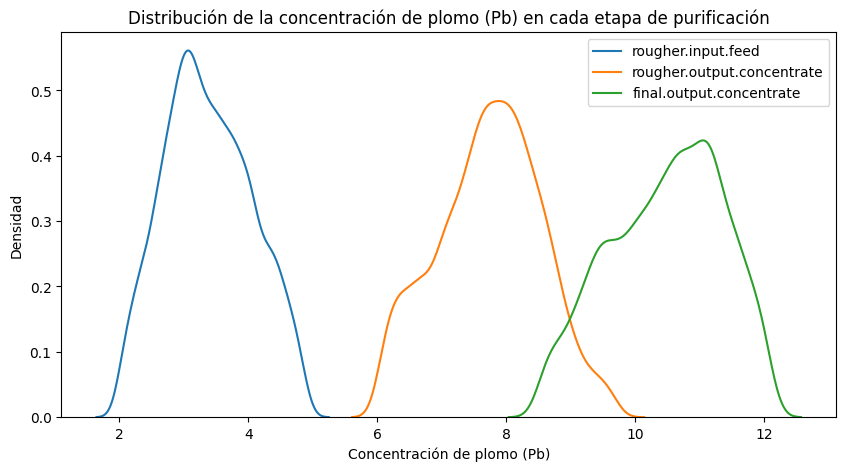

In [1221]:
# Eliminar las anomalías en las distribuciones de las concentraciones de plomo (Pb) en las diferentes etapas de purificación en el conjunto de entrenamiento
for stage in stages:
    q_low = df_train[f'{stage}_pb'].quantile(lower_bound)
    q_hi  = df_train[f'{stage}_pb'].quantile(upper_bound)
    df_train = df_train[(df_train[f'{stage}_pb'] < q_hi) & (df_train[f'{stage}_pb'] > q_low)]

# Mostar la distribución de la concentración de plomo (Pb) en cada etapa de purificación
ig, ax = plt.subplots(figsize=(10, 5))
for stage in stages:
    sns.kdeplot(df_train[f'{stage}_pb'], label=stage, ax=ax)
plt.title('Distribución de la concentración de plomo (Pb) en cada etapa de purificación')
plt.xlabel('Concentración de plomo (Pb)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# Construcción del modelo

## Función para calcular el valor final de sMAPE

    sMAPE = (1 / N) * sum(abs(y - y_pred) / ((abs(y) + abs(y_pred)) / 2)) * 100%
    sMAPE final = 25% * sMAPE(rougher) + 75% * sMAPE(final)

In [1222]:
# Crear una función para calcular el valor de la función sMAPE
def smape(y, y_pred):
    return (1 / len(y)) * np.sum(np.abs(y - y_pred) / ((np.abs(y) + np.abs(y_pred)) / 2)) * 100

# Crear una función para calcular el valor de la función final sMAPE
def final_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

## Entrenamiento del modelo

`Características elegidas para el modelo`:

- Estas características proporcionan información tanto sobre la calidad del mineral como sobre los parámetros del proceso de flotación y purificación.

- La fecha (date) puede ser relevante si se identifican patrones temporales en los datos, aunque también puede introducir ruido si no se maneja correctamente.

- Las características que describen el "estado" de las máquinas (rougher.state.floatbank10_a_air, rougher.state.floatbank10_a_level, etc.) podrían ser relevantes, pero esto dependerá de la relación entre estos estados y la eficacia de la extracción de oro.

In [1223]:
# Características elegidas para el modelo
chosen_features = [
    'primary_cleaner.input.sulfate',
    'primary_cleaner.input.depressant',
    'primary_cleaner.input.feed_size',
    'primary_cleaner.input.xanthate',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
]

# Objetivos elegido para el modelo
chosen_targets = [
    'rougher.output.recovery',
    'final.output.recovery'
]

In [1224]:
# Filtrar el conjunto de entrenamiento con las características y objetivos elegidos
chosen_train_df = df_train[chosen_features + chosen_targets]

# Filtrar las características del conjunto de entrenamiento
train_features = chosen_train_df[chosen_features]

# Filtrar los objetivos del conjunto de entrenamiento
train_targets = chosen_train_df[chosen_targets]

# Filtrar el conjunto de prueba con las características elegidas
test_features = df_test[chosen_features]

# Filtrar el conjunto completo para obtener los objetivos de prueba
test_targets = df_full[df_full.index.isin(df_test.index)][chosen_targets]

# Tamaño de los conjuntos de entrenamiento (características y objetivos)
print('Tamaño de train_features:', train_features.shape)
print('Tamaño de train_targets:', train_targets.shape, '\n')

# Tamaño de los conjuntos de prueba (características y objetivos)
print('Tamaño de test_features:', test_features.shape)
print('Tamaño de test_targets:', test_targets.shape)

Tamaño de train_features: (5852, 14)
Tamaño de train_targets: (5852, 2) 

Tamaño de test_features: (5270, 14)
Tamaño de test_targets: (5270, 2)


### Encontrar los mejores hiperparámetros para cada modelo

In [1225]:
# Crear una función para encontrar los mejores hiperparámetros
def find_best_params(model, param_grid, train_features, train_targets):
    # Realizar una búsqueda en cuadrícula de los hiperparámetros
    grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid.fit(train_features, train_targets)
    
    # Imprimir los mejores hiperparámetros y el mejor score
    print('Tipo de modelo:', type(model).__name__)
    print('Mejores parámetros:', grid.best_params_)
    print('Mejor score:', np.abs(grid.best_score_))

In [1226]:
# Definir los hiperparámetros a probar
param_grid_lr = {}
param_grid_rf = {'n_estimators': np.arange(50, 201, 50), 'max_depth': np.arange(3, 15)}
param_grid_dt = {'max_depth': np.arange(3, 15)}

In [1227]:
# Encontrar los mejores hiperparámetros
# model_lr = LinearRegression()
# find_best_params(model_lr, param_grid_lr, train_features, train_targets)

# model_rf = RandomForestRegressor(random_state=12345)
# find_best_params(model_rf, param_grid_rf, train_features, train_targets)

# model_dt = DecisionTreeRegressor(random_state=12345)
# find_best_params(model_dt, param_grid_dt, train_features, train_targets)

### Conclusión intermedia

Los siguientes fueron los mejores hiperparámetros obtenidos para cada modelo utilizando búsqueda en cuadrícula con validación cruzada (`GridSearchCV`):

- `Regresión Lineal`: {}
- `Bosque aleatorio`: {'max_depth': 5, 'n_estimators': 50}
- `Árbol de decisiones`: {'max_depth': 3}

In [1228]:
# Crear función para entrenar y evaluar cada modelo
def train_and_evaluate(model, train_features, train_targets, test_features, test_targets):
    model.fit(train_features, train_targets)
    predictions = model.predict(test_features)
    smape_rougher = smape(test_targets['rougher.output.recovery'], predictions[:, 0])
    smape_final = smape(test_targets['final.output.recovery'], predictions[:, 1])
    final_smape_score = final_smape(smape_rougher, smape_final)
    print('sMAPE rougher:', smape_rougher)
    print('sMAPE final:', smape_final)
    print('sMAPE final total:', final_smape_score)

### Regresión Lineal

In [1229]:
# Crear modelo de regresión lineal
model_lr = LinearRegression()

# Entrenar y evaluar el modelo de regresión lineal
train_and_evaluate(model_lr, train_features, train_targets, test_features, test_targets)

sMAPE rougher: 19.14442482032417
sMAPE final: 17.622899226720104
sMAPE final total: 18.00328062512112


### Bosque aleatorio

In [1230]:
# Crear modelo de regresión random forest
model_rf = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=5)

# Entrenar y evaluar el modelo de regresión random forest
train_and_evaluate(model_rf, train_features, train_targets, test_features, test_targets)

sMAPE rougher: 18.121233605724782
sMAPE final: 16.670801774686915
sMAPE final total: 17.03340973244638


### Árbol de decisiones

In [1231]:
# Crear modelo de regresión decision tree
model_dt = DecisionTreeRegressor(random_state=12345, max_depth=3)

# Entrenar y evaluar el modelo de regresión decision tree
train_and_evaluate(model_dt, train_features, train_targets, test_features, test_targets)


sMAPE rougher: 17.19936835740275
sMAPE final: 15.185535540353493
sMAPE final total: 15.688993744615807


### Conclusión intermedia

- `Regresión Lineal`: Proporciona un sMAPE final de 18.00%, bueno pero no el mejor.
- `Bosque Aleatorio`: Con ajustes de hiperparámetros (profundidad máxima de 5 y 50 estimadores), ofrece un sMAPE final mejorado de 17.03%.
- `Árbol de Decisiones`: A pesar de su simplicidad, con una profundidad máxima de 3, logró el sMAPE final más bajo de 15.69%, superando a los otros modelos.

# Conclusión general

Durante este proyecto, creamos modelos de regresión lineal, bosque aleatorio y árbol de decisiones para pronosticar la recuperación de oro a partir de características del proceso de purificación. Usamos validación cruzada para evaluar la precisión y la robustez de los modelos.

- Se utilizó la validación cruzada para estimar la incertidumbre de las predicciones y determinar la exactitud y robustez de los modelos.
- El modelo de `Árbol de decisiones` con una `profundidad máxima de 3` demostró tener el `sMAPE final más bajo`, lo que indica la mejor precisión entre los modelos.

En conclusión, el modelo de `árbol de decisiones con una profundidad máxima de 3` resultó ser el más adecuado para predecir la recuperación del oro, logrando el `sMAPE final más bajo de 15.69%`, lo que indica alta precisión y robustez.

A continuación los resultados del modelo elegido:
- `sMAPE rougher`: **17.20%**
- `sMAPE final`: **15.19%**
- `sMAPE final total`: **15.69%**